Using this credit card fraud dataset develop an algorithm to predict fraud. Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('../../../Supervised_lesson6/Credit_card_fraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


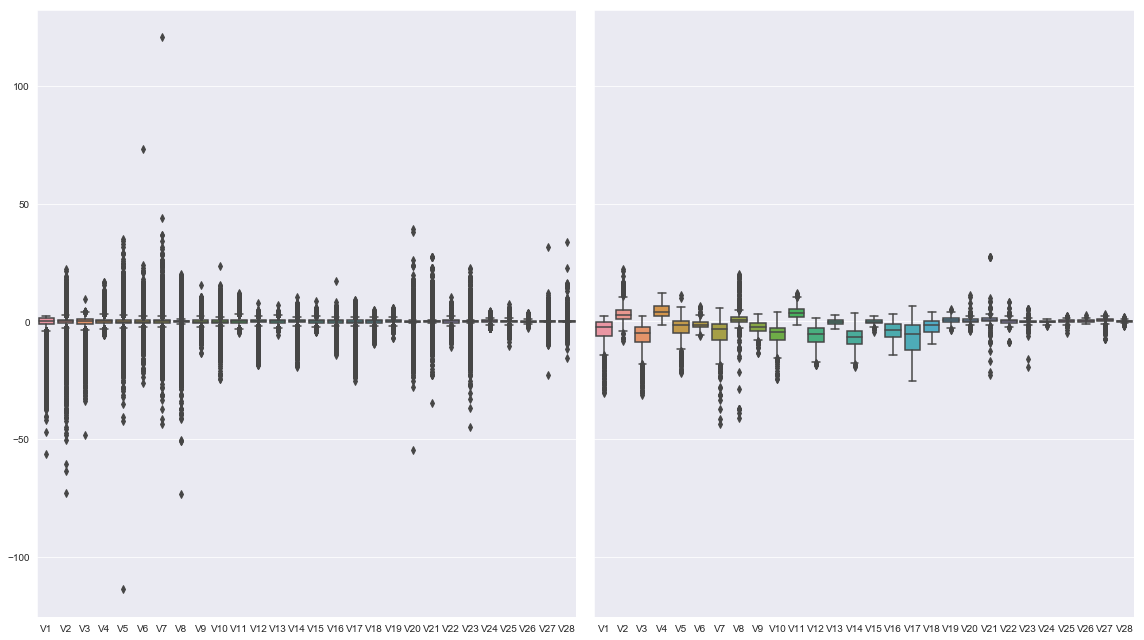

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row', figsize=(16,9))
sns.boxplot(data=df.drop(['Time', 'Amount', 'Class'], axis=1), ax=ax1)
sns.boxplot(data=df[df.Class == 1].drop(['Time', 'Amount', 'Class'], axis=1), ax=ax2)
plt.tight_layout()

In [4]:
df[df.Amount > 17500]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
58465,48401.0,-36.802320,-63.344698,-20.645794,16.715537,-20.672064,7.694002,24.956587,-4.730111,-2.687312,...,11.455313,-10.933144,-17.173665,1.180700,-7.025783,-2.534330,-3.602479,3.450224,19656.53,0
151296,95286.0,-34.549296,-60.464618,-21.340854,16.875344,-19.229075,6.335259,24.422716,-4.964566,0.188912,...,11.502580,-9.499423,-16.513186,0.744341,-7.081325,-2.604551,-3.550963,3.250802,18910.00,0
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.347360,-3.872425,...,-21.620120,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0


C:\Users\seapea\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


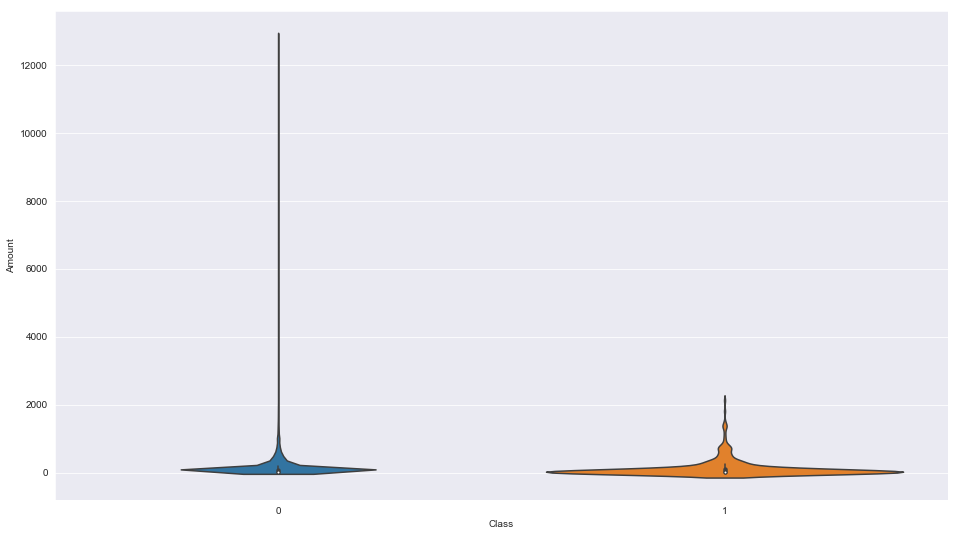

In [5]:
fig, ax = plt.subplots(figsize=(16,9))
sns.violinplot(data=df[df.Amount < 17500][['Class', 'Amount']], x='Class', y='Amount')

In [6]:
X = df.drop(['Time', 'Class'], axis=1)
y = df.Class

# This is a lengthy computation - putting it into pickle format
# tsne = TSNE()
# tsne_red_X = tsne.fit_transform(X)
# with open('tsne_red', 'wb') as file:
#     pickle.dump(tsne_red_X, file)
    
with open('tsne_red', 'rb') as file:
    tsne_red_X = pickle.load(file)

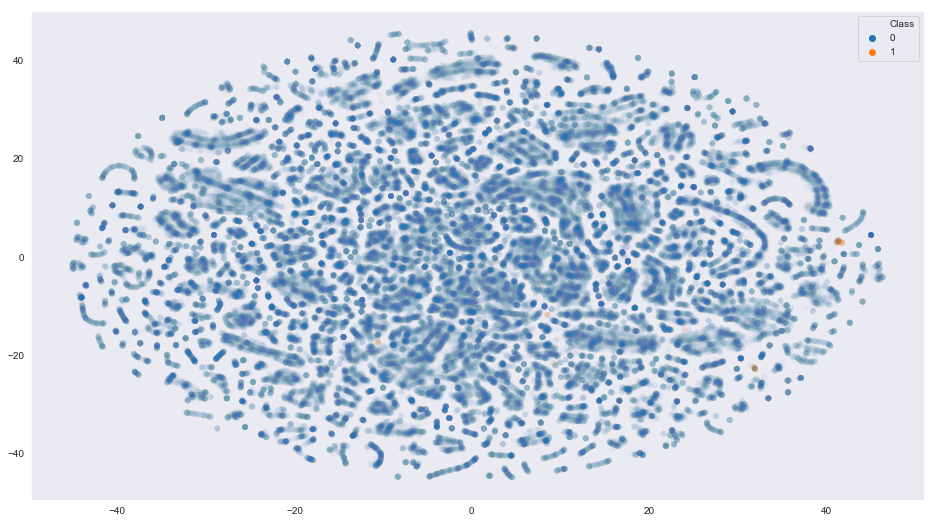

In [11]:
sns.set_style('dark')
fig, ax = plt.subplots(figsize=(16,9))
sns.scatterplot(x=tsne_red_X[:,0], y=tsne_red_X[:,1], hue=y, alpha=0.01)

In [50]:
s1, s2, s3, s4, s5 = StratifiedKFold(n_splits=5).split(X, y)

In [56]:
df.iloc[s1[0]]['Class'].value_counts()

0    227452
1       393
Name: Class, dtype: int64

In [57]:
df.iloc[s1[1]]['Class'].value_counts()

0    56863
1       99
Name: Class, dtype: int64

In [58]:
X = df.drop(['Time', 'Class'], axis=1)
y = df.Class

In [ ]:
clf_log = LogisticRegression()
clf_grad = GradientBoostingClassifier()
clf_knn = KNeighborsClassifier()

